# Notebook to produce a performance diagram

In [1]:
import sys, os
#change path to path of current skript, where also utility.py lies
sys.path.append('C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/code_and_data/')

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib 
from climada import CONFIG
import colorcet as cc
from utility import data_dir,read_at_centroid_data, compute_verification_stats


Now specify which crops set datadir and figure directory

In [3]:
#%% SETUP
croptypes=['wheat','maize','barley','rapeseed']#,['Weizen'],['Mais'],['Gerste'],['Raps'],['Aepfel'],['Reben']]
datadir = f"{data_dir}/data_at_centroid/"
figdir = 'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/fig/'
   

read data for croptypes and each hazard

In [5]:
at_centroid_data={}
# load data for MESHS 

for var in ['MESHS']:
    data, croptype = read_at_centroid_data(datadir,croptypes,variable=var)
    at_centroid_data[var]=data

Set up settings for figure

In [6]:
#%% Colors Markers
colors=['k','dimgrey','lightgrey','wheat','darkgoldenrod','sienna']
markers=['.','*','d','o','v','s']

#all available resolutions 
resolutions=['1km','2km','4km','8km', '16km', '32km']

#resolutions to be plotted
opt_resolutions=['1km','4km','8km']


# Hazard variable
variable='MESHS'
#select
at_centroid_data_var=at_centroid_data[variable]
#unit 
unit='mm' #r'Jm$^{-2}$' #'%' #r'Jm$^{-2}$'

#hazard thresholds to be plotted
opt_threshs=[20,30,40]
#opt_threshs=[70,90,100]
#opt_threshs=[100,150,200]
#opt_threshs=[60,80,100]
#opt_threshs=[50,100,150]

#exposure thresholds (minimum number of fields within grid for grid to count as exposure point)
exp_threshs=[0]

#scores on x axis (1-FAR) for performance diagramm and POFD for ROC curve 
scores=['1-FAR'] #,'POFD']

#colorbar label (CSI for Performance diagram and HK for ROC curve)
clabs=['CSI'] #,'HK']

#fontsizes
font_s=16
font_l=20
matplotlib.rcParams.update({'font.size': font_l, 'axes.labelsize':font_l})
    



Plot Figure

C:\Users\F80840370\AppData\Local\Temp\ipykernel_8972\1658840832.py:13: RuntimeWarning: divide by zero encountered in divide
  B=y1/x1
C:\Users\F80840370\AppData\Local\Temp\ipykernel_8972\1658840832.py:13: RuntimeWarning: invalid value encountered in divide
  B=y1/x1
C:\Users\F80840370\AppData\Local\Temp\ipykernel_8972\1658840832.py:14: RuntimeWarning: divide by zero encountered in divide
  CSI=1/(1/x1+1/y1-1)


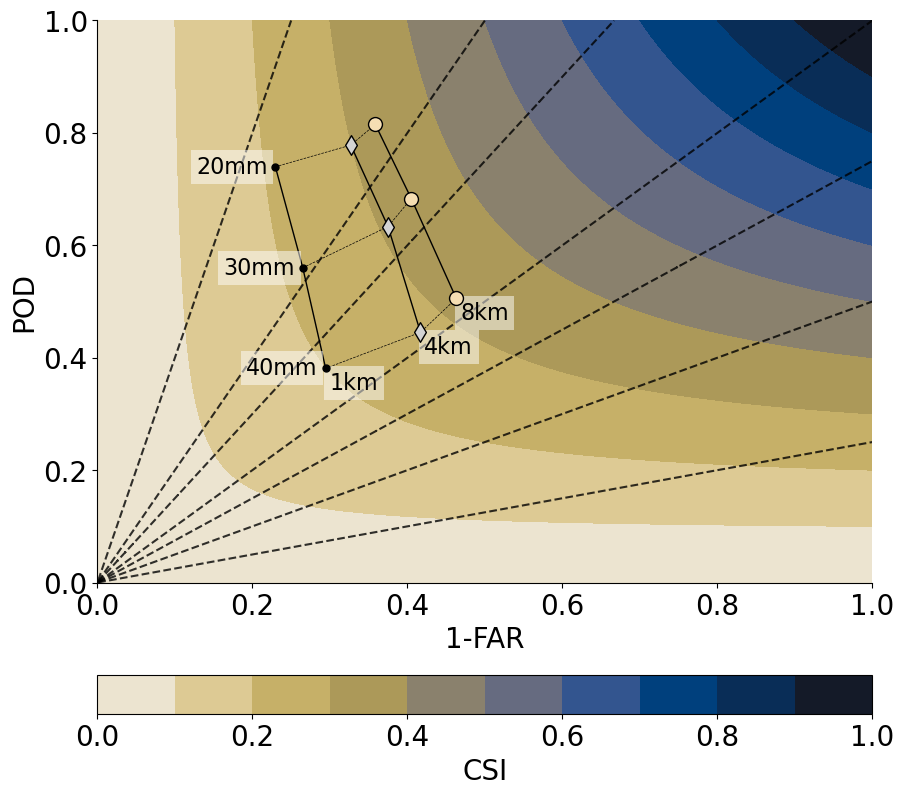

In [7]:
fig,axs=plt.subplots(figsize=(10,10),nrows=1,ncols=len(scores),sharey=True)
if not isinstance(axs,list):
    axs=[axs]
plt.subplots_adjust(wspace=0.1)

#prepare skill score an bias plot
pofds=np.arange(0,0.5,0.001)
fars=np.arange(0,1.001,0.001)
pods=np.arange(0,1.001,0.001)
x1,y1=np.meshgrid(fars,pods)
x2,y2=np.meshgrid(pofds,pods)
hk=y2-x2
B=y1/x1
CSI=1/(1/x1+1/y1-1)

# levels
B_levs=[0.25,0.5,0.75,1,1.5,2,4]
CSI_levs=np.arange(0,1.1,0.1)
HK_levs=np.arange(-1,1.1,0.2)


def get_uneven_cmap(cmap_rb,uneven_levels):
    import matplotlib.colors as mcolors    
    
    cols = cmap_rb(np.linspace(0, 1, len(uneven_levels) - 1))
    cmap, norm = mcolors.from_levels_and_colors(uneven_levels, cols)
    
    return cmap, norm

#loop over axis (length of axs is 1 if only performance diagram plotted)
for j,ax in enumerate(axs):
    score=scores[j]

    if j==0: # PERFORMANCE DIAGRAM
        hl=ax.contour(x1,y1,B,levels=B_levs,colors='k',alpha=0.8,linestyles='dashed')
        h=ax.contourf(x1,y1,CSI,cmap=cc.cm.CET_CBL1_r,levels=CSI_levs)
        ax.set_ylabel('POD')
        #ax.set_xlabel('1-FAR')
    if j==1: # ROC DIAGRAM 
        cmap,norm=get_uneven_cmap(cc.cm.bwy_r, HK_levs)
        h=ax.contourf(x2,y2,hk,cmap=cmap,norm=norm,levels=HK_levs)

    #add colorbar
    fig.colorbar(h,ax=ax,location='bottom',pad=0.12,label=clabs[j])

    #plot points in diagram
    for l,th in enumerate(exp_threshs):
        x_threshs={thresh: [] for thresh in opt_threshs}
        y_threshs={thresh: [] for thresh in opt_threshs}
        for i,res in enumerate(resolutions):
            if res not in opt_resolutions:
                continue
            
    
            df, npred = compute_verification_stats(at_centroid_data_var[res],
                                               variable = variable,
                                               exposure_thresh=th)
     
            
            #df_sel=df[(df['B']>0.5) & (df['B']<2) & (df['HK']>0.4) & (df['HSS']>0.3)]
            #h=ax.scatter(df_sel[score],df_sel.POD,color=colors[i],marker=markers[i],label=res)
            
            #plot POD vs Score
            x,y=(df[score][opt_threshs],df.POD.loc[opt_threshs])
            for thresh in opt_threshs:
                x_threshs[thresh].append(x[thresh])
                y_threshs[thresh].append(y[thresh])

            if l==0:
                h2=ax.plot(x,y,color='k',linewidth=1)
                h=ax.scatter(df[score][opt_threshs],df.POD.loc[opt_threshs],color=colors[i],marker=markers[i],s=100,edgecolor='k',label=res,zorder=10)
                x,y=df[score][opt_threshs],df.POD.loc[opt_threshs]  

            elif l>0:
                h2=ax.plot(x,y,color='r',linewidth=2,alpha=1)
                #h=ax.scatter(df[score][opt_threshs],df.POD.loc[opt_threshs],color='dimgrey',marker=markers[i],s=100,edgecolor='k',label=res,zorder=10,alpha=0.5)
   
            if l==0:
                #Annotate resolutions
                if len(exp_threshs)==1:
                    ax.annotate(f'{res}',(x.values[-1],y.values[-1]),
                                xytext=(x.values[-1]+0.005,y.values[-1]-0.005),
                                xycoords='data',
                               fontsize=font_s,va='top',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                    
                #annotate thresholds
                x,y=df[score][opt_threshs],df.POD.loc[opt_threshs]  
                if res=='1km':
                    for k,thresh in enumerate(opt_threshs):
                        if j==0:
                            ax.annotate(f'{thresh}{unit}',(x.values[k],y.values[k]),
                                        xytext=(x.values[k]-0.01,y.values[k]),
                                        xycoords='data',
                                       fontsize=font_s,va='center',ha='right',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                        else:
                            ax.annotate(f'{thresh}{unit}',(x.values[k],y.values[k]),
                                        xytext=(x.values[k]-0.005,y.values[k]),
                                        xycoords='data',
                                       fontsize=font_s,va='center',ha='right',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                    
        for thresh in opt_threshs:
            if l==0:
                ax.plot(x_threshs[thresh],y_threshs[thresh],color='k',linestyle='dashed',linewidth=0.5)
            elif l>0:
                ax.plot(x_threshs[thresh],y_threshs[thresh],color='r',linestyle='dashed',linewidth=2)

        ax.spines[['right', 'top']].set_visible(False)
        #ax.text(0,1.05,labels[j],
                    #transform=ax.transAxes,fontweight='bold')
        #ax.set_title('POD',fontweight='bold',pad=0)
        ax.set_xlabel(score)
        
        ax.set_ylim([0,1])
        if j==0:
            ax.set_xlim([0,1])
        if j==1:
            ax.set_xlim([0,0.3])
            leg=ax.legend(ncol=1,loc='center', title='resolution',bbox_to_anchor=(1.2,0.5),edgecolor='none')
            leg._legend_box.align = "left"
            
#plt.clabel(hl,manual=True,fontsize=font_s)


Now save figure

In [111]:
fig.savefig(f'{figdir}/Figure_Skill_BIAS_summary_{variable}_{croptype}_{exp_threshs}_P2.png',dpi=300,bbox_inches='tight')
fig.savefig(f'{figdir}/Figure_Skill_BIAS_summary_{variable}_{croptype}_{exp_threshs}_P2.pdf',dpi=300,bbox_inches='tight')


Plot performance diagram with the "optimal setups"

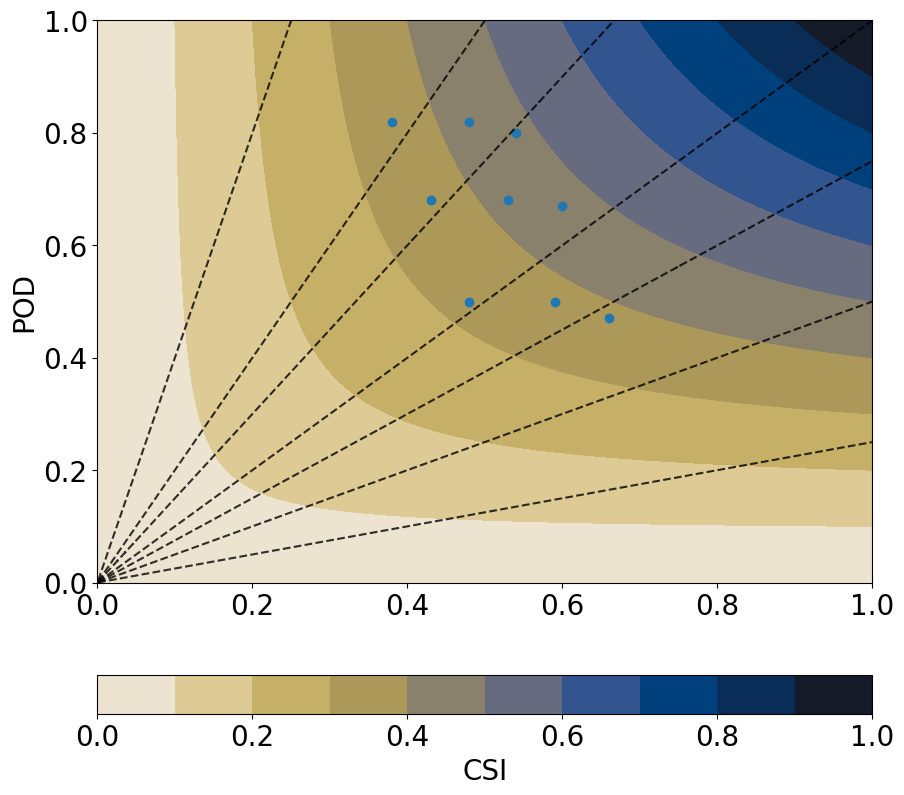

In [11]:
setup=['(8,20,100)','(8,20,20)','(8,20,1)','(8,20,100)','(8,30,20)','(8,30,1)','(8,40,100)','(8,40,20)','(8,40,1)']
PODS=[0.8,0.82,0.82,0.67,0.68,0.68,0.47,0.50,0.50]
FARS=[0.46,0.52,0.62,0.40,0.47,0.57,0.34,0.41,0.52]

fig,ax=plt.subplots(figsize=(10,10),nrows=1,ncols=1)

# PERFORMANCE DIAGRAM
hl=ax.contour(x1,y1,B,levels=B_levs,colors='k',alpha=0.8,linestyles='dashed')
h=ax.contourf(x1,y1,CSI,cmap=cc.cm.CET_CBL1_r,levels=CSI_levs)
ax.set_ylabel('POD')

#add colorbar
fig.colorbar(h,ax=ax,location='bottom',pad=0.12,label=clabs[j])
ax.scatter(1-np.array(FARS),PODS)


fig,axs=plt.subplots(figsize=(10,10),nrows=1,ncols=len(scores),sharey=True)
if not isinstance(axs,list):
    axs=[axs]
plt.subplots_adjust(wspace=0.1)

#prepare skill score an bias plot
pofds=np.arange(0,0.5,0.001)
fars=np.arange(0,1.001,0.001)
pods=np.arange(0,1.001,0.001)
x1,y1=np.meshgrid(fars,pods)
x2,y2=np.meshgrid(pofds,pods)
hk=y2-x2
B=y1/x1
CSI=1/(1/x1+1/y1-1)

# levels
B_levs=[0.25,0.5,0.75,1,1.5,2,4]
CSI_levs=np.arange(0,1.1,0.1)
HK_levs=np.arange(-1,1.1,0.2)


def get_uneven_cmap(cmap_rb,uneven_levels):
    import matplotlib.colors as mcolors    
    
    cols = cmap_rb(np.linspace(0, 1, len(uneven_levels) - 1))
    cmap, norm = mcolors.from_levels_and_colors(uneven_levels, cols)
    
    return cmap, norm

#loop over axis (length of axs is 1 if only performance diagram plotted)
for j,ax in enumerate(axs):
    score=scores[j]

    if j==0: # PERFORMANCE DIAGRAM
        hl=ax.contour(x1,y1,B,levels=B_levs,colors='k',alpha=0.8,linestyles='dashed')
        h=ax.contourf(x1,y1,CSI,cmap=cc.cm.CET_CBL1_r,levels=CSI_levs)
        ax.set_ylabel('POD')
        #ax.set_xlabel('1-FAR')
    if j==1: # ROC DIAGRAM 
        cmap,norm=get_uneven_cmap(cc.cm.bwy_r, HK_levs)
        h=ax.contourf(x2,y2,hk,cmap=cmap,norm=norm,levels=HK_levs)

    #add colorbar
    fig.colorbar(h,ax=ax,location='bottom',pad=0.12,label=clabs[j])

    #plot points in diagram
    for l,th in enumerate(exp_threshs):
        x_threshs={thresh: [] for thresh in opt_threshs}
        y_threshs={thresh: [] for thresh in opt_threshs}
        for i,res in enumerate(resolutions):
            if res not in opt_resolutions:
                continue
            
    
            df, npred = compute_verification_stats(at_centroid_data_var[res],
                                               variable = variable,
                                               exposure_thresh=th)
     
            
            #df_sel=df[(df['B']>0.5) & (df['B']<2) & (df['HK']>0.4) & (df['HSS']>0.3)]
            #h=ax.scatter(df_sel[score],df_sel.POD,color=colors[i],marker=markers[i],label=res)
            
            #plot POD vs Score
            x,y=(df[score][opt_threshs],df.POD.loc[opt_threshs])
            for thresh in opt_threshs:
                x_threshs[thresh].append(x[thresh])
                y_threshs[thresh].append(y[thresh])

            if l==0:
                h2=ax.plot(x,y,color='k',linewidth=1)
                h=ax.scatter(df[score][opt_threshs],df.POD.loc[opt_threshs],color=colors[i],marker=markers[i],s=100,edgecolor='k',label=res,zorder=10)
                x,y=df[score][opt_threshs],df.POD.loc[opt_threshs]  

            elif l>0:
                h2=ax.plot(x,y,color='r',linewidth=2,alpha=1)
                #h=ax.scatter(df[score][opt_threshs],df.POD.loc[opt_threshs],color='dimgrey',marker=markers[i],s=100,edgecolor='k',label=res,zorder=10,alpha=0.5)
   
            if l==0:
                #Annotate resolutions
                if len(exp_threshs)==1:
                    ax.annotate(f'{res}',(x.values[-1],y.values[-1]),
                                xytext=(x.values[-1]+0.005,y.values[-1]-0.005),
                                xycoords='data',
                               fontsize=font_s,va='top',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                    
                #annotate thresholds
                x,y=df[score][opt_threshs],df.POD.loc[opt_threshs]  
                if res=='1km':
                    for k,thresh in enumerate(opt_threshs):
                        if j==0:
                            ax.annotate(f'{thresh}{unit}',(x.values[k],y.values[k]),
                                        xytext=(x.values[k]-0.01,y.values[k]),
                                        xycoords='data',
                                       fontsize=font_s,va='center',ha='right',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                        else:
                            ax.annotate(f'{thresh}{unit}',(x.values[k],y.values[k]),
                                        xytext=(x.values[k]-0.005,y.values[k]),
                                        xycoords='data',
                                       fontsize=font_s,va='center',ha='right',bbox=dict(facecolor='white', edgecolor='none',alpha=0.5))   
                    
        for thresh in opt_threshs:
            if l==0:
                ax.plot(x_threshs[thresh],y_threshs[thresh],color='k',linestyle='dashed',linewidth=0.5)
            elif l>0:
                ax.plot(x_threshs[thresh],y_threshs[thresh],color='r',linestyle='dashed',linewidth=2)

        ax.spines[['right', 'top']].set_visible(False)
        #ax.text(0,1.05,labels[j],
                    #transform=ax.transAxes,fontweight='bold')
        #ax.set_title('POD',fontweight='bold',pad=0)
        ax.set_xlabel(score)
        
        ax.set_ylim([0,1])
        if j==0:
            ax.set_xlim([0,1])
        if j==1:
            ax.set_xlim([0,0.3])
            leg=ax.legend(ncol=1,loc='center', title='resolution',bbox_to_anchor=(1.2,0.5),edgecolor='none')
            leg._legend_box.align = "left"
            
#plt.clabel(hl,manual=True,fontsize=font_s)